In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

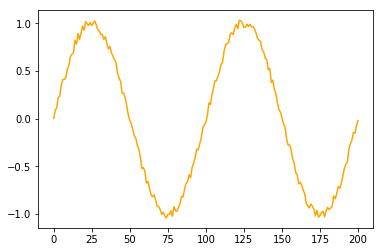

In [3]:
T = 100
f = toy_problem(T)
plt.plot(f, color='orange')
plt.show()

In [4]:
length_of_sequences = 2 * T  # 全時系列の長さ
maxlen = 25  # １つの時系列の長さ

data = []
target = []

for i in range(0, length_of_sequences - maxlen + 1):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])

In [5]:
X = np.array(data).reshape(len(data), maxlen, 1)
Y = np.array(target).reshape(len(data), 1)

In [6]:
N_train = int(len(data) * 0.9)
N_validation = len(data) - N_train

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=N_validation)

# TensorFlowによる実装

In [7]:
def inference(x, n_batch, maxlen=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    cell = tf.contrib.rnn.BasicRNNCell(n_hidden)
    initial_state = cell.zero_state(n_batch, tf.float32)
    state = initial_state
    outputs = []  # 過去の隠れ層の出力を保存
    with tf.variable_scope('RNN'):
        for t in range(maxlen):
            if t > 0:
                tf.get_variable_scope().reuse_variables()
            (cell_output, state) = cell(x[:, t, :], state)
            outputs.append(cell_output)
    output = outputs[-1]
    
    V = weight_variable([n_hidden, n_out])
    c = bias_variable([n_out])
    y = tf.matmul(output, V) + c  # 線形活性
    return y

In [8]:
def loss(y, t):
    return tf.reduce_mean(tf.square(y-t))

def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    
    train_step = optimizer.minimize(loss)
    return train_step

In [9]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [10]:
n_in = len(X[0][0])
n_hidden = 20
n_out = len(Y[0])

In [11]:
x = tf.placeholder(tf.float32, shape=[None, maxlen, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])
n_batch = tf.placeholder(tf.int32, shape=[])

In [12]:
y = inference(x, n_batch, maxlen=maxlen, n_hidden=n_hidden, n_out=n_out)
loss = loss(y, t)
train_step = training(loss)

In [13]:
epochs = 500
batch_size = 10

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size
early_stopping = EarlyStopping(patience=10, verbose=1)


for epoch in range(epochs):
        X_, Y_ = shuffle(X_train, Y_train)

        for i in range(n_batches):
            start = i * batch_size
            end = start + batch_size

            sess.run(train_step, feed_dict={
                x: X_[start:end],
                t: Y_[start:end],
                n_batch: batch_size
                })
            
            val_loss = loss.eval(session=sess, feed_dict={
                x: X_validation,
                t: Y_validation,
                n_batch: N_validation
            })   
            
            # 値を記録しておく
            print('epoch: ', epoch,
                 ' validation loss: ', val_loss)
            
            if early_stopping.validate(val_loss):
                break

epoch:  0  validation loss:  0.433579
epoch:  0  validation loss:  0.427454
epoch:  0  validation loss:  0.421496
epoch:  0  validation loss:  0.415026
epoch:  0  validation loss:  0.407999
epoch:  0  validation loss:  0.40101
epoch:  0  validation loss:  0.393623
epoch:  0  validation loss:  0.38596
epoch:  0  validation loss:  0.377923
epoch:  0  validation loss:  0.369673
epoch:  0  validation loss:  0.361003
epoch:  0  validation loss:  0.351956
epoch:  0  validation loss:  0.34242
epoch:  0  validation loss:  0.332612
epoch:  0  validation loss:  0.322677
epoch:  1  validation loss:  0.312264
epoch:  1  validation loss:  0.301684
epoch:  1  validation loss:  0.291022
epoch:  1  validation loss:  0.280103
epoch:  1  validation loss:  0.269069
epoch:  1  validation loss:  0.258097
epoch:  1  validation loss:  0.247179
epoch:  1  validation loss:  0.23651
epoch:  1  validation loss:  0.226091
epoch:  1  validation loss:  0.215862
epoch:  1  validation loss:  0.205682
epoch:  1  valid

epoch:  64  validation loss:  0.00226147
early stopping
epoch:  65  validation loss:  0.00237505
early stopping
epoch:  66  validation loss:  0.00219923
early stopping
epoch:  67  validation loss:  0.00199504
early stopping
epoch:  68  validation loss:  0.0016947
early stopping
epoch:  69  validation loss:  0.00143665
epoch:  69  validation loss:  0.00155095
epoch:  69  validation loss:  0.00182726
epoch:  69  validation loss:  0.00207665
epoch:  69  validation loss:  0.00230385
epoch:  69  validation loss:  0.00237591
epoch:  69  validation loss:  0.00250412
epoch:  69  validation loss:  0.00261923
epoch:  69  validation loss:  0.00274314
epoch:  69  validation loss:  0.00285398
epoch:  69  validation loss:  0.00276486
epoch:  69  validation loss:  0.00261916
early stopping
epoch:  70  validation loss:  0.00251735
early stopping
epoch:  71  validation loss:  0.00244769
early stopping
epoch:  72  validation loss:  0.00231189
early stopping
epoch:  73  validation loss:  0.00212667
early

epoch:  242  validation loss:  0.00136961
early stopping
epoch:  243  validation loss:  0.00151017
early stopping
epoch:  244  validation loss:  0.0015834
early stopping
epoch:  245  validation loss:  0.00171234
early stopping
epoch:  246  validation loss:  0.00171606
early stopping
epoch:  247  validation loss:  0.00164239
early stopping
epoch:  248  validation loss:  0.00167121
early stopping
epoch:  249  validation loss:  0.00167421
early stopping
epoch:  250  validation loss:  0.0015135
early stopping
epoch:  251  validation loss:  0.00136808
early stopping
epoch:  252  validation loss:  0.00122914
early stopping
epoch:  253  validation loss:  0.00113547
epoch:  253  validation loss:  0.00113434
epoch:  253  validation loss:  0.00120015
epoch:  253  validation loss:  0.00123965
epoch:  253  validation loss:  0.00127826
epoch:  253  validation loss:  0.00139698
epoch:  253  validation loss:  0.00148618
epoch:  253  validation loss:  0.00151001
epoch:  253  validation loss:  0.001506

epoch:  375  validation loss:  0.00222592
early stopping
epoch:  376  validation loss:  0.00216798
early stopping
epoch:  377  validation loss:  0.00199666
early stopping
epoch:  378  validation loss:  0.00173686
early stopping
epoch:  379  validation loss:  0.00141191
early stopping
epoch:  380  validation loss:  0.00116784
early stopping
epoch:  381  validation loss:  0.00100181
epoch:  381  validation loss:  0.000935185
epoch:  381  validation loss:  0.000995034
epoch:  381  validation loss:  0.00107535
epoch:  381  validation loss:  0.00110782
epoch:  381  validation loss:  0.00105107
epoch:  381  validation loss:  0.00104819
epoch:  381  validation loss:  0.0011088
epoch:  381  validation loss:  0.00119889
epoch:  381  validation loss:  0.00133954
epoch:  381  validation loss:  0.00154872
epoch:  381  validation loss:  0.00177336
epoch:  381  validation loss:  0.00189484
early stopping
epoch:  382  validation loss:  0.00201014
early stopping
epoch:  383  validation loss:  0.001869

In [14]:
truncate = maxlen
Z = X[:1]
original = [f[i] for i in range(maxlen)]
predicted = [None for i in range(maxlen)]

In [15]:
for i in range(length_of_sequences - maxlen + 1):
    z_ = Z[-1:]
    y_ = y.eval(session=sess, feed_dict={
        x: Z[-1:],
        n_batch: 1
    })
    
    sequence_ = np.concatenate(
    (z_.reshape(maxlen, n_in)[1:], y_), axis=0).reshape(1, maxlen, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

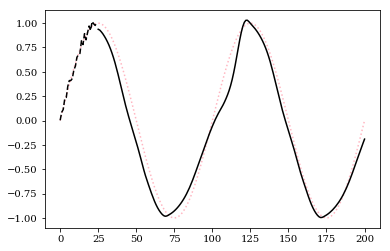

In [16]:
plt.rc('font', family='serif')
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='lightpink')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()

# Kerasによる実装

In [17]:
from keras.optimizers import Adam
from keras.layers import Dense, Activation
from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [18]:
def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)

In [19]:
model = Sequential()
model.add(SimpleRNN(n_hidden, init=weight_variable,
                   input_shape=(maxlen, n_in)))
model.add(Dense(n_out, init=weight_variable))
model.add(Activation('linear'))

In [20]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [22]:
epochs = 500
batch_size = 10

model.fit(X_train, Y_train, batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_validation, Y_validation),
         callbacks=[early_stopping])

Train on 158 samples, validate on 18 samples
Epoch 1/500
158/158 [==============================] - 0s 2ms/step - loss: 0.4749 - val_loss: 0.3597
Epoch 2/500
158/158 [==============================] - 0s 481us/step - loss: 0.4096 - val_loss: 0.2701
Epoch 3/500
158/158 [==============================] - 0s 495us/step - loss: 0.3356 - val_loss: 0.2079
Epoch 4/500
158/158 [==============================] - 0s 512us/step - loss: 0.2465 - val_loss: 0.1240
Epoch 5/500
158/158 [==============================] - 0s 663us/step - loss: 0.1281 - val_loss: 0.0417
Epoch 6/500
158/158 [==============================] - 0s 432us/step - loss: 0.0478 - val_loss: 0.0280
Epoch 7/500
158/158 [==============================] - 0s 403us/step - loss: 0.0323 - val_loss: 0.0172
Epoch 8/500
158/158 [==============================] - 0s 434us/step - loss: 0.0258 - val_loss: 0.0221
Epoch 9/500
158/158 [==============================] - 0s 488us/step - loss: 0.0217 - val_loss: 0.0245
Epoch 10/500
158/158 [========

In [23]:
truncate = 25
Z = X[:1]

original = [f[i] for i in range(25)]
predicted = [None for i in range(25)]

for i in range(200 - 25 + 1):
    z_ = Z[-1:]
    y_ = model.predict(z_)
    sequence_ = np.concatenate(
    (z_.reshape(25, n_in)[1:], y_),
    axis=0).reshape(1, 25, n_in)
    Z = np.append(Z, sequence_, axis=0)
    predicted.append(y_.reshape(-1))

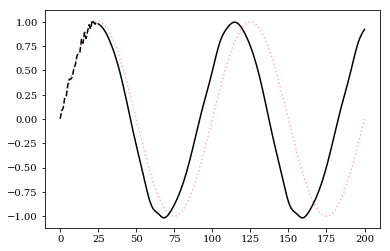

In [24]:
plt.rc('font', family='serif')
plt.plot(toy_problem(T, ampl=0), linestyle='dotted', color='lightpink')
plt.plot(original, linestyle='dashed', color='black')
plt.plot(predicted, color='black')
plt.show()